In [1]:
import xml.dom.minidom
import numpy as np
import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

### обработка данных 

Загрузка данных из xml.

В данных присутствет "мусор", поэтому необходимо его удалить.

Для более рациональной кластеризации заменим адрес сайтов на слово "сайт" и четыре подряд идущие цифры на "дата" (так как скорее всего это год).

In [2]:
data_original = [] # все запросы без изменений
data = [] # "очищенные" данные

In [3]:
for path in ["last20x.xml","last20x (1).xml","last20x (2).xml","last20x (3).xml","last20x (4).xml",
             "last20x (5).xml","last20x (6).xml","last20x (7).xml","last20x (8).xml","last20x (9).xml"]:
    dom = xml.dom.minidom.parse(path);
    dom.normalize()
    nodes=dom.getElementsByTagName("item")
    for node in nodes:
        stroka = node.childNodes[0].nodeValue
        data_original.append(stroka)
        stroka = stroka.lower()
        stroka = re.sub(r'\d{4}', u'дата', stroka)
        stroka = re.sub(r'[^\s]+\.(?:ru|com|org)[^\s]*', u'сайт', stroka)
        stroka = re.sub(r'[\"\'\.+\,\:\-\d+]', u'', stroka)
        data.append(stroka)

In [4]:
len(data)

10000

Составляем словарь из слов в запросах. Слова перед этим приводим к нормальной форме.

In [6]:
data_split = []
dic = {}
for d in data:
    request = []
    for s in d.split():
        p = morph.parse(s)[0]
        request.append(p.normal_form)
        if p.normal_form in dic:
            dic[p.normal_form] += 1
        else:
            dic[p.normal_form] = 1
    data_split.append(request)

In [7]:
len(dic)

12918

Исключаем из словаря слова, которые встречаются редко (меньше 3 раз), предлоги и союзы. А также присваиваем каждому слову свой индекс.

In [9]:
dic_id = {}
predlog = {u'в', u'без', u'до', u'из', u'к', u'на', u'по', u'о', u'от', u'перед', u'при', u'через',
           u'с', u'у', u'за', u'над', u'об', u'под', u'про', u'для'}
souz = {u'и',u'а',u'но',u'или'}
n_id = 0
for d in dic:
    if dic[d] > 2 and d not in predlog and d not in souz:
        dic_id[d] = n_id
        n_id += 1

In [10]:
len(dic_id)

2352

Создаем матрицу признаков.

In [11]:
X = np.zeros((10000,len(dic_id)))
for i in range(10000):
    for word in data_split[i]:
        if word in dic_id:
            X[i,dic_id[word]] += 1

Отображаем данные в двухмерное пространство с помощию метода t-SNE

In [12]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
model = TSNE(random_state=1)
tsne_representation = model.fit_transform(X)

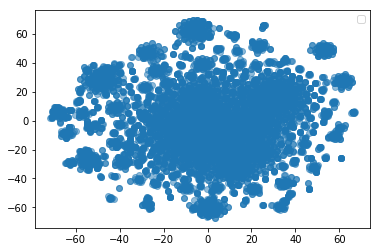

In [14]:
plt.scatter(tsne_representation[:, 0], 
                tsne_representation[:, 1], alpha=0.5)
plt.legend()

### кластеризация

In [15]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

ms = AgglomerativeClustering(n_clusters=20)
ms.fit(tsne_representation)
labels_AC = ms.labels_


Wall time: 0 ns


(-80, 80)

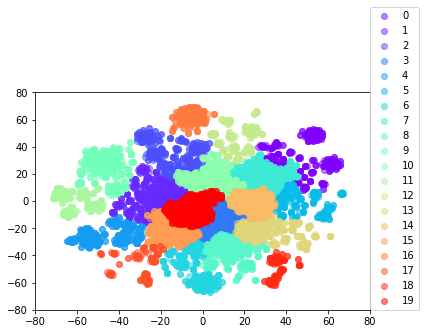

In [44]:
colors = cm.rainbow(np.linspace(0, 1, len(set(labels_AC))))
for y, c in zip(set(np.unique(labels_AC)), colors):
    plt.scatter(tsne_representation[labels_AC==y, 0], 
                tsne_representation[labels_AC==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend(loc=(1.,0.))
plt.xlim(-80, 80)
plt.ylim(-80, 80)

In [19]:
from sklearn.cluster import KMeans

ms = KMeans(n_clusters = 20)
ms.fit(tsne_representation)
labels_KM = ms.labels_

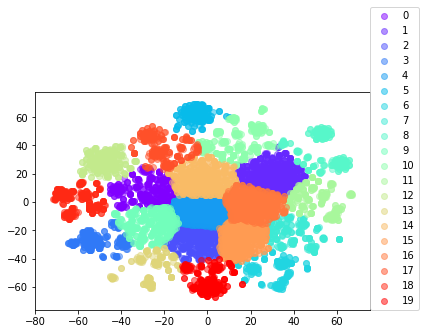

In [51]:
colors = cm.rainbow(np.linspace(0, 1, len(set(labels_KM))))
for y, c in zip(set(np.unique(labels_KM)), colors):
    plt.scatter(tsne_representation[labels_KM==y, 0], 
                tsne_representation[labels_KM==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()
plt.legend(loc=(1.,0.))

In [17]:
from sklearn.cluster import MeanShift

ms = MeanShift(bandwidth=13.)
ms.fit(tsne_representation)
labels_MS = ms.labels_

Wall time: 0 ns


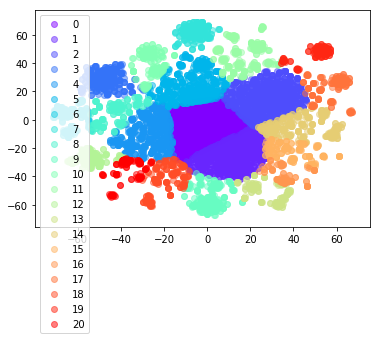

In [18]:
colors = cm.rainbow(np.linspace(0, 1, len(set(labels_MS))))
for y, c in zip(set(np.unique(labels_MS)), colors):
    plt.scatter(tsne_representation[labels_MS==y, 0], 
                tsne_representation[labels_MS==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()

 Все методы кластеризации, представленные здесь, сработали примерно одинаково. Однако, для интерпретации классов будем рассматривать алгоритм kmeans, так как он наиболее прост в реализации и, как следствие, быстрее работает. 
Как видно из графика, все классы интерпретировать довольно затруднительно, но все же есть классы, которые хорошо выделяются из общей массы:

3 класс - запросы на скачивание чего-либо;

5 класс - запросы о покупках;

6 класс - люди пытаются найти ответ на вопрос "Что это такое?";

8 класс - запросы на поиск сайта;

12 класс - запросы про что-то произошедшее в определённом году;

13 класс - хотят узнать погоду;

17 класс - поиск различных фотографий;

18 класс - запросы на поиск фильмов;

19 класс - люди пытаются найти ответ на вопрос "Как сделать что-то?".